<a href="https://colab.research.google.com/github/appliedcode/mthree-c422/blob/mthree-c422-Likhitha/Filter_methods_Fisher_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')
print("Original features:", list(X.columns))

Original features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [ ]:
def fisher_score(X_df, y_arr):
    scores = []
    classes = np.unique(y_arr)
    for col in X_df.columns:
        overall_mean = X_df[col].mean()
        num = den = 0
        for cls in classes:
            Xi = X_df[col][y_arr == cls]
            num += len(Xi) * (Xi.mean() - overall_mean) ** 2
            den += len(Xi) * Xi.var()
        scores.append(num / den if den else 0)
    return scores

fs = fisher_score(X, y)
fs_df = pd.DataFrame({'feature': X.columns, 'Fisher_score': fs}).sort_values(by='Fisher_score', ascending=False)
print("\nFisher Scores:\n", fs_df)


Fisher Scores:
              feature  Fisher_score
2  petal length (cm)     15.735482
3   petal width (cm)     12.800095
0  sepal length (cm)      1.590193
1   sepal width (cm)      0.655467


In [ ]:
anova_selector = SelectKBest(score_func=f_classif, k=X.shape[1])
anova_selector.fit(X, y)
df_anova = pd.DataFrame({
    'feature': X.columns,
    'F_score': anova_selector.scores_
}).sort_values(by='F_score', ascending=False)


In [ ]:
df_compare = fs_df.merge(df_anova, on='feature')
print("\nComparison of Fisher Scores and ANOVA F-scores:\n", df_compare)

# Correlation coefficient
corr = df_compare['Fisher_score'].corr(df_compare['F_score'])
print(f"\nCorrelation between Fisher score and ANOVA F-score: {corr:.3f}")


Comparison of Fisher Scores and ANOVA F-scores:
              feature  Fisher_score      F_score
0  petal length (cm)     15.735482  1180.161182
1   petal width (cm)     12.800095   960.007147
2  sepal length (cm)      1.590193   119.264502
3   sepal width (cm)      0.655467    49.160040

Correlation between Fisher score and ANOVA F-score: 1.000


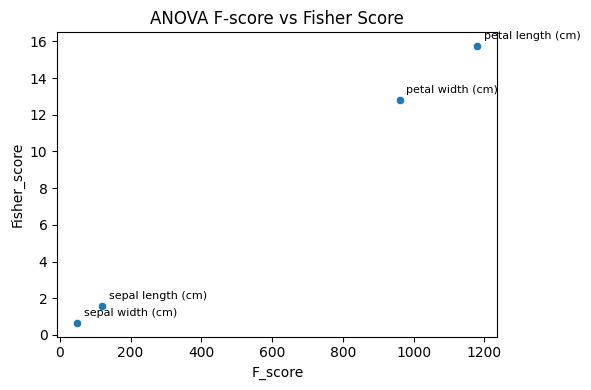

In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='F_score', y='Fisher_score', data=df_compare)
plt.title('ANOVA F-score vs Fisher Score')
for i, row in df_compare.iterrows():
    plt.annotate(row['feature'], (row['F_score'], row['Fisher_score']),
                 xytext=(5,5), textcoords='offset points', fontsize=8)
plt.tight_layout()
plt.show()

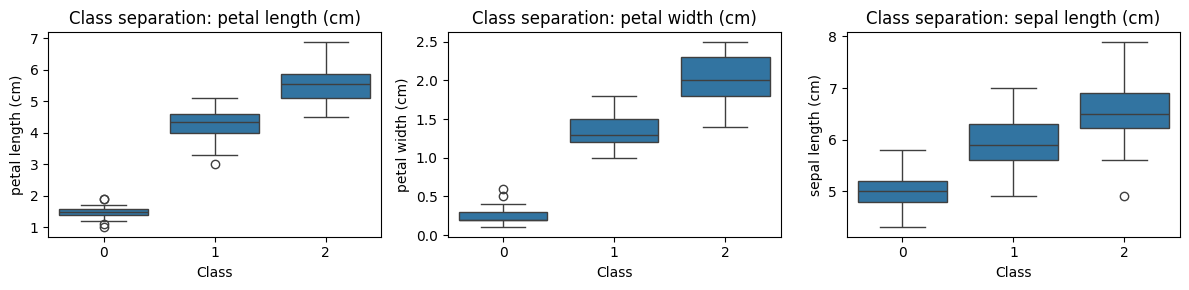

In [ ]:
top_features = fs_df['feature'].head(3).tolist()
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, feat in enumerate(top_features):
    sns.boxplot(x=y, y=X[feat], ax=axes[i])
    axes[i].set_title(f"Class separation: {feat}")
    axes[i].set_xlabel('Class')
plt.tight_layout()
plt.show()

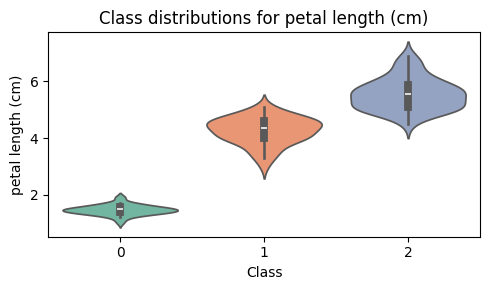

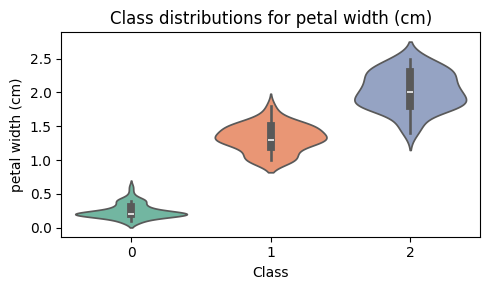

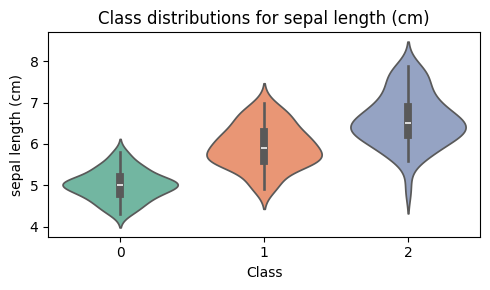

In [ ]:
for feat in top_features:
    plt.figure(figsize=(5,3))
    sns.violinplot(x=y, y=X[feat], hue=y, palette='Set2', legend=False)
    plt.title(f"Class distributions for {feat}")
    plt.xlabel('Class')
    plt.ylabel(feat)
    plt.tight_layout()
    plt.show()

In [ ]:
print("\n=== Manual Fisher Score Verification ===")
top_feature = fs_df['feature'].iloc[0]
col_data = X[top_feature]
overall_mean = col_data.mean()
classes = np.unique(y)

print(f"Verifying Fisher score for: {top_feature}")
print(f"Overall mean: {overall_mean:.3f}")

between_class_var = 0
within_class_var = 0

for cls in classes:
    class_data = col_data[y == cls]
    class_mean = class_data.mean()
    class_var = class_data.var()
    class_size = len(class_data)

    between_contrib = class_size * (class_mean - overall_mean) ** 2
    within_contrib = class_size * class_var

    between_class_var += between_contrib
    within_class_var += within_contrib

    print(f"Class {cls}: mean={class_mean:.3f}, var={class_var:.3f}, size={class_size}")
    print(f"  Between contribution: {between_contrib:.3f}")
    print(f"  Within contribution: {within_contrib:.3f}")

manual_fisher = between_class_var / within_class_var if within_class_var else 0
computed_fisher = fs_df[fs_df['feature'] == top_feature]['Fisher_score'].iloc[0]

print(f"\nManual Fisher score: {manual_fisher:.6f}")
print(f"Function Fisher score: {computed_fisher:.6f}")
print(f"Match: {abs(manual_fisher - computed_fisher) < 1e-10}")


=== Manual Fisher Score Verification ===
Verifying Fisher score for: petal length (cm)
Overall mean: 3.758
Class 0: mean=1.462, var=0.030, size=50
  Between contribution: 263.581
  Within contribution: 1.508
Class 1: mean=4.260, var=0.221, size=50
  Between contribution: 12.600
  Within contribution: 11.041
Class 2: mean=5.552, var=0.305, size=50
  Between contribution: 160.922
  Within contribution: 15.229

Manual Fisher score: 15.735482
Function Fisher score: 15.735482
Match: True


In [ ]:
def fisher_score(X_df, y_arr):
    fisher_scores = {}
    classes = np.unique(y_arr)

    for feature in X_df.columns:
        overall_mean = X_df[feature].mean()
        numerator = 0
        denominator = 0

        for cls in classes:
            class_values = X_df[feature][y_arr == cls]
            class_mean = class_values.mean()
            class_var = class_values.var()
            class_size = len(class_values)

            numerator += class_size * (class_mean - overall_mean) ** 2
            denominator += class_size * class_var

        score = numerator / denominator if denominator else 0
        fisher_scores[feature] = score

    return pd.Series(fisher_scores, name='Fisher_score').sort_values(ascending=False)


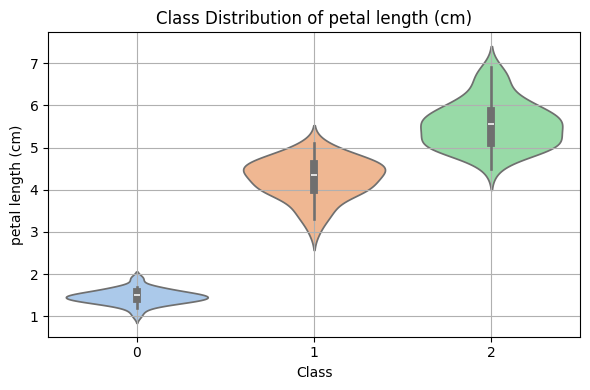

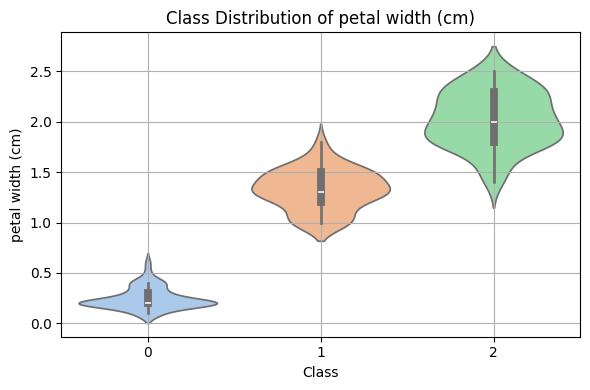

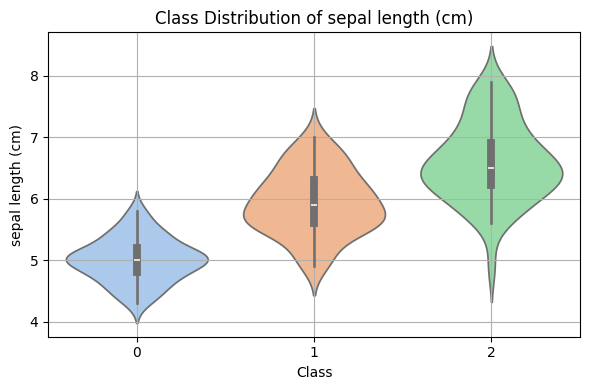

In [ ]:
# Set a color palette for consistency
sns.set_palette('pastel')

# Draw violin plots for top features
for feature in top_features:
    plt.figure(figsize=(6, 4))
    sns.violinplot(x=y, y=X[feature], hue=y, palette='pastel', legend=False)
    plt.title(f'Class Distribution of {feature}')
    plt.xlabel('Class')
    plt.ylabel(feature)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


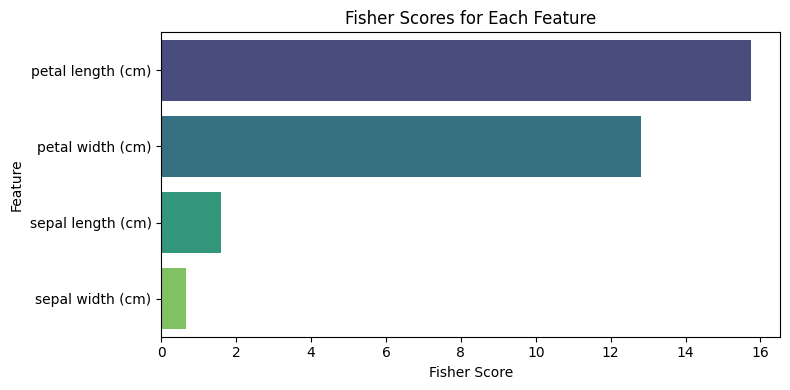

In [ ]:
# Add a dummy 'hue' column to avoid the warning
fs_df['hue'] = fs_df['feature']  # using feature names as hue for unique color per row

plt.figure(figsize=(8, 4))
sns.barplot(x='Fisher_score', y='feature', hue='hue', data=fs_df, palette='viridis', dodge=False, legend=False)
plt.title("Fisher Scores for Each Feature")
plt.xlabel("Fisher Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Optional cleanup
fs_df.drop(columns='hue', inplace=True)
